In [5]:
from models.stage1.vq import VectorQuantize
from utils import load_yaml_param_settings, quantize
import numpy as np
import pandas
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
conf_dir = 'configs/config.yaml'

config = load_yaml_param_settings(conf_dir)

In [6]:
dim = 64
vq = VectorQuantize(dim, config["VQVAE"]["codebook"]["size"], **config["VQVAE"])

#load the vq model
dir = 'saved_models/vqmodel-FordA.ckpt'
vq.load_state_dict(torch.load(dir))

<All keys matched successfully>

In [15]:
vq._codebook.training = False
print(vq._codebook.training)


False


In [39]:
codebook = vq.codebook

codebook_norm = codebook / torch.norm(codebook, dim=1, keepdim=True)

corr = torch.corrcoef(codebook_norm)
torch.sum(torch.abs(corr - torch.eye(corr.shape[0]))) / (corr.shape[0] * (corr.shape[0] - 1))

tensor(0.3628)

In [40]:
cosine_similarity = F.cosine_similarity(codebook_norm.unsqueeze(0), codebook_norm.unsqueeze(1), dim=2)
torch.sum(torch.abs(cosine_similarity - torch.eye(cosine_similarity.shape[0]))) / (cosine_similarity.shape[0] * (cosine_similarity.shape[0] - 1))

tensor(0.3561)

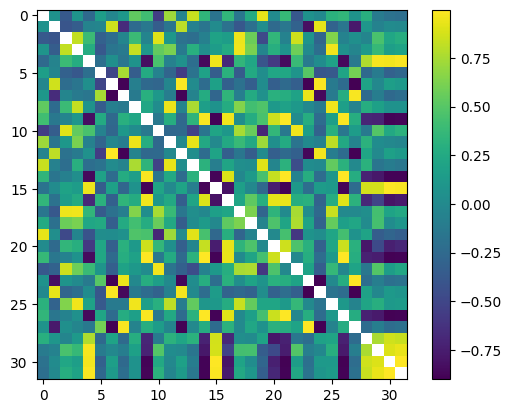

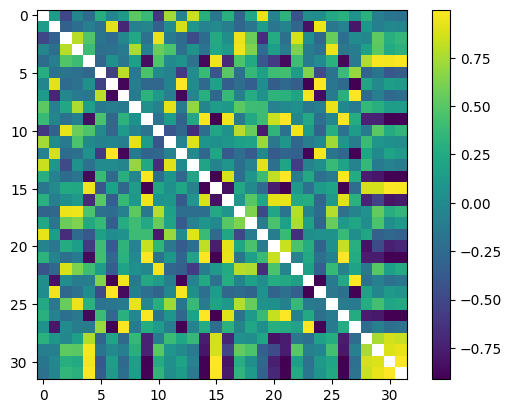

In [41]:
corr.fill_diagonal_(np.nan)
cosine_similarity.fill_diagonal_(np.nan)

plt.imshow(cosine_similarity)
plt.colorbar()
plt.show()
plt.close()
plt.imshow(corr)
plt.colorbar()
plt.show()

In [42]:
def enhanced_decorrelation_loss(codebook, device):
    # Compute the correlation matrix of the codebook vectors
    corr = torch.corrcoef(codebook).to(device)
    # Create an identity matrix for reference (perfect decorrelation)
    identity = torch.eye(corr.shape[0]).to(device)
    # Calculate the squared difference from the identity matrix for off-diagonal elements
    # This squares the correlation values, penalizing higher correlations more
    squared_diff = (corr - identity) ** 2
    # We zero out the diagonal because we are only interested in off-diagonal elements
    squared_diff = squared_diff * (1 - identity)
    # Sum up all the squared differences and normalize by the number of off-diagonal elements
    decorr_loss = torch.sum(squared_diff) / (corr.shape[0] * (corr.shape[0] - 1))
    return decorr_loss 

In [43]:
print(enhanced_decorrelation_loss(codebook, 'cuda:0'))

tensor(0.2229, device='cuda:0')


In [44]:

def abs_correlation_loss(codebook, device):
    corr_matrix = torch.abs(torch.corrcoef(codebook).to(device))

    # Create an identity matrix of the same size as the covariance matrix
    identity_matrix = torch.eye(corr_matrix.size(0)).to(device)

    # Calculate loss as the sum of squared off-diagonal elements of the covariance matrix
    # This is equivalent to minimizing the Frobenius norm of the off-diagonal elements
    off_diagonal_mask = 1 - identity_matrix
    off_diagonal_elements = corr_matrix * off_diagonal_mask
    decorr_loss = torch.norm(off_diagonal_elements, p="fro") ** 2 / (
        corr_matrix.size(0) * (corr_matrix.size(0) - 1)
    )

    return decorr_loss

def correlation_loss(codebook, device):

    corr_matrix = torch.corrcoef(codebook).to(device)

    # Create an identity matrix of the same size as the covariance matrix
    identity_matrix = torch.eye(corr_matrix.size(0)).to(device)

    # Calculate loss as the sum of squared off-diagonal elements of the covariance matrix
    # This is equivalent to minimizing the Frobenius norm of the off-diagonal elements
    off_diagonal_mask = 1 - identity_matrix
    off_diagonal_elements = corr_matrix * off_diagonal_mask
    decorr_loss = torch.norm(off_diagonal_elements, p="fro") ** 2 / (
        corr_matrix.size(0) * (corr_matrix.size(0) - 1)
    )

    return decorr_loss


def covariance_loss(codebook, device):

    codebook_mean = torch.mean(codebook, dim=0, keepdim=True)
    codebook_centered = codebook - codebook_mean
    cov_matrix = torch.matmul(codebook_centered.T, codebook_centered) / (
        codebook.size(0) - 1
    )

    # Create an identity matrix of the same size as the covariance matrix
    identity_matrix = torch.eye(cov_matrix.size(0)).to(device)

    # Calculate loss as the sum of squared off-diagonal elements of the covariance matrix
    # This is equivalent to minimizing the Frobenius norm of the off-diagonal elements
    off_diagonal_mask = 1 - identity_matrix
    off_diagonal_elements = cov_matrix * off_diagonal_mask
    decorr_loss = torch.norm(off_diagonal_elements, p="fro") ** 2 / (
        cov_matrix.size(0) * (cov_matrix.size(0) - 1)
    )

    return decorr_loss


In [45]:
test = torch.rand_like(codebook)
print(covariance_loss(codebook, 'cpu'), "random", covariance_loss(test, 'cpu'))
print(correlation_loss(codebook, 'cpu'), "random", correlation_loss(test, 'cpu'))
print(abs_correlation_loss(codebook, 'cpu'), "random", abs_correlation_loss(test, 'cpu'))

tensor(3.1981) random tensor(0.0002)
tensor(0.2229) random tensor(0.0151)
tensor(0.2229) random tensor(0.0151)


In [18]:
def exponential_weight_schedule(
    current_epoch, max_epoch, start_weight, end_weight, base=2
):
    if current_epoch > max_epoch:
        return end_weight
    else:
        epoch_ratio = current_epoch / max_epoch
        weight = start_weight + (end_weight - start_weight) * (
            (base**epoch_ratio) - 1
        ) / (base - 1)
        return weight